# An example of masterplan creation

In [2]:
import os
import sys
from pathlib import Path
project_dir = Path().resolve().parent.parent
sys.path.append(str(project_dir))

os.environ["USE_PYGEOS"] = os.environ.get("USE_PYGEOS", "0")
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
from IPython.display import Markdown

from masterplan_tools.method import MasterPlan, balance_data
from masterplan_tools.method.provision import ProvisionModel
from masterplan_tools.models import CityModel
from masterplan_tools.preprocessing import DataGetter


def pandas_to_markdown(df_or_series: pd.DataFrame | pd.Series, value_name: str | None = None) -> Markdown:
    if isinstance(df_or_series, pd.DataFrame):
        return Markdown(
            "\n".join(
                (
                    f"| {' | '.join(column for column in df_or_series.columns)} |",
                    f"| {' | '.join(('---',) * df_or_series.shape[1])} |",
                    "\n".join(
                        f"| {' | '.join(str(value) for value in values)} |" for _, values in df_or_series.iterrows()
                    ),
                )
            )
        )
    elif isinstance(df_or_series, pd.Series):
        if value_name is None:
            value_name = "value"
        return Markdown(
            "\n".join(
                (
                    f"| {df_or_series.name} | {value_name} |",
                    "| --- | --- |",
                    "\n".join(f"| {key} | {round(value)} |" for key, value in df_or_series.items()),
                )
            )
        )
    raise ValueError(f"'{df_or_series}' is neither DataFrame nor Series")

#### City model creation

In [2]:
# path to data
example_data_path = "./data"
# TODO: upload example data somewhere and download it in script


# load data required for blocks creation
city_geometry = gpd.read_parquet(os.path.join(example_data_path, "city_geometry.parquet"))
water_geometry = gpd.read_parquet(os.path.join(example_data_path, "water_geometry.parquet"))
roads_geometry = gpd.read_parquet(os.path.join(example_data_path, "roads_geometry.parquet"))
railways_geometry = gpd.read_parquet(os.path.join(example_data_path, "railways_geometry.parquet"))
nature_geometry_boundaries = gpd.read_parquet(os.path.join(example_data_path, "nature_geometry_boundaries.parquet"))

# load data required for service graphs creation
schools = gpd.read_parquet(os.path.join(example_data_path, "schools.parquet"))
kindergartens = gpd.read_parquet(os.path.join(example_data_path, "kindergartens.parquet"))
recreational_areas = gpd.read_parquet(os.path.join(example_data_path, "recreational_areas.parquet"))

hospitals = gpd.read_file(os.path.join(example_data_path, "hospitals.geojson"))
pharmacies = gpd.read_file(os.path.join(example_data_path, "pharmacies.geojson"))
policlinics = gpd.read_file(os.path.join(example_data_path, "policlinics.geojson"))
# accessibility_matrix = pd.read_pickle(path + "accessibility_matrix.pkl")

# load data required for
buildings = gpd.read_parquet(os.path.join(example_data_path, "buildings.parquet"))
greenings = gpd.read_parquet(os.path.join(example_data_path, "greenings.parquet"))
parkings = gpd.read_parquet(os.path.join(example_data_path, "parkings.parquet"))


transport_graph = nx.read_graphml(os.path.join(example_data_path, "new_graph.graphml"))

# data loading with planning area
polygon = gpd.read_file(os.path.join(example_data_path, "polygon.geojson"))

In [3]:
# services should be specified as a dictionary
services = {"schools": schools, "kindergartens": kindergartens, "recreational_areas": recreational_areas, "hospitals": hospitals, "pharmacies": pharmacies, "policlinics": policlinics}

In [4]:
# City data model creation
city_model = CityModel(
    services=services,
    city_geometry=city_geometry,
    water_geometry=water_geometry,
    roads_geometry=roads_geometry,
    railways_geometry=railways_geometry,
    nature_geometry_boundaries=nature_geometry_boundaries,
    # accessibility_matrix=accessibility_matrix,
    transport_graph=transport_graph,
    buildings=buildings,
    greenings=greenings,
    parkings=parkings,
)

Restoring living area:   0%|          | 0/3748 [00:00<?, ?it/s]

Restoring living area squash:   0%|          | 0/3748 [00:00<?, ?it/s]

In [7]:
file = gpd.read_feather('/Users/mvin/Desktop/masterplanning/data/spb_buildings_geom.feather')

ArrowInvalid: Not an Arrow file

In [ ]:
file

#### Calculating the provision of services in blocks

In [ ]:
services_prov = {}

for service_type in services.keys():
    provision = ProvisionModel(city_model=city_model, service_name=service_type)
    print(service_type)
    services_prov[service_type] = provision.run()

#### Service provision visualization

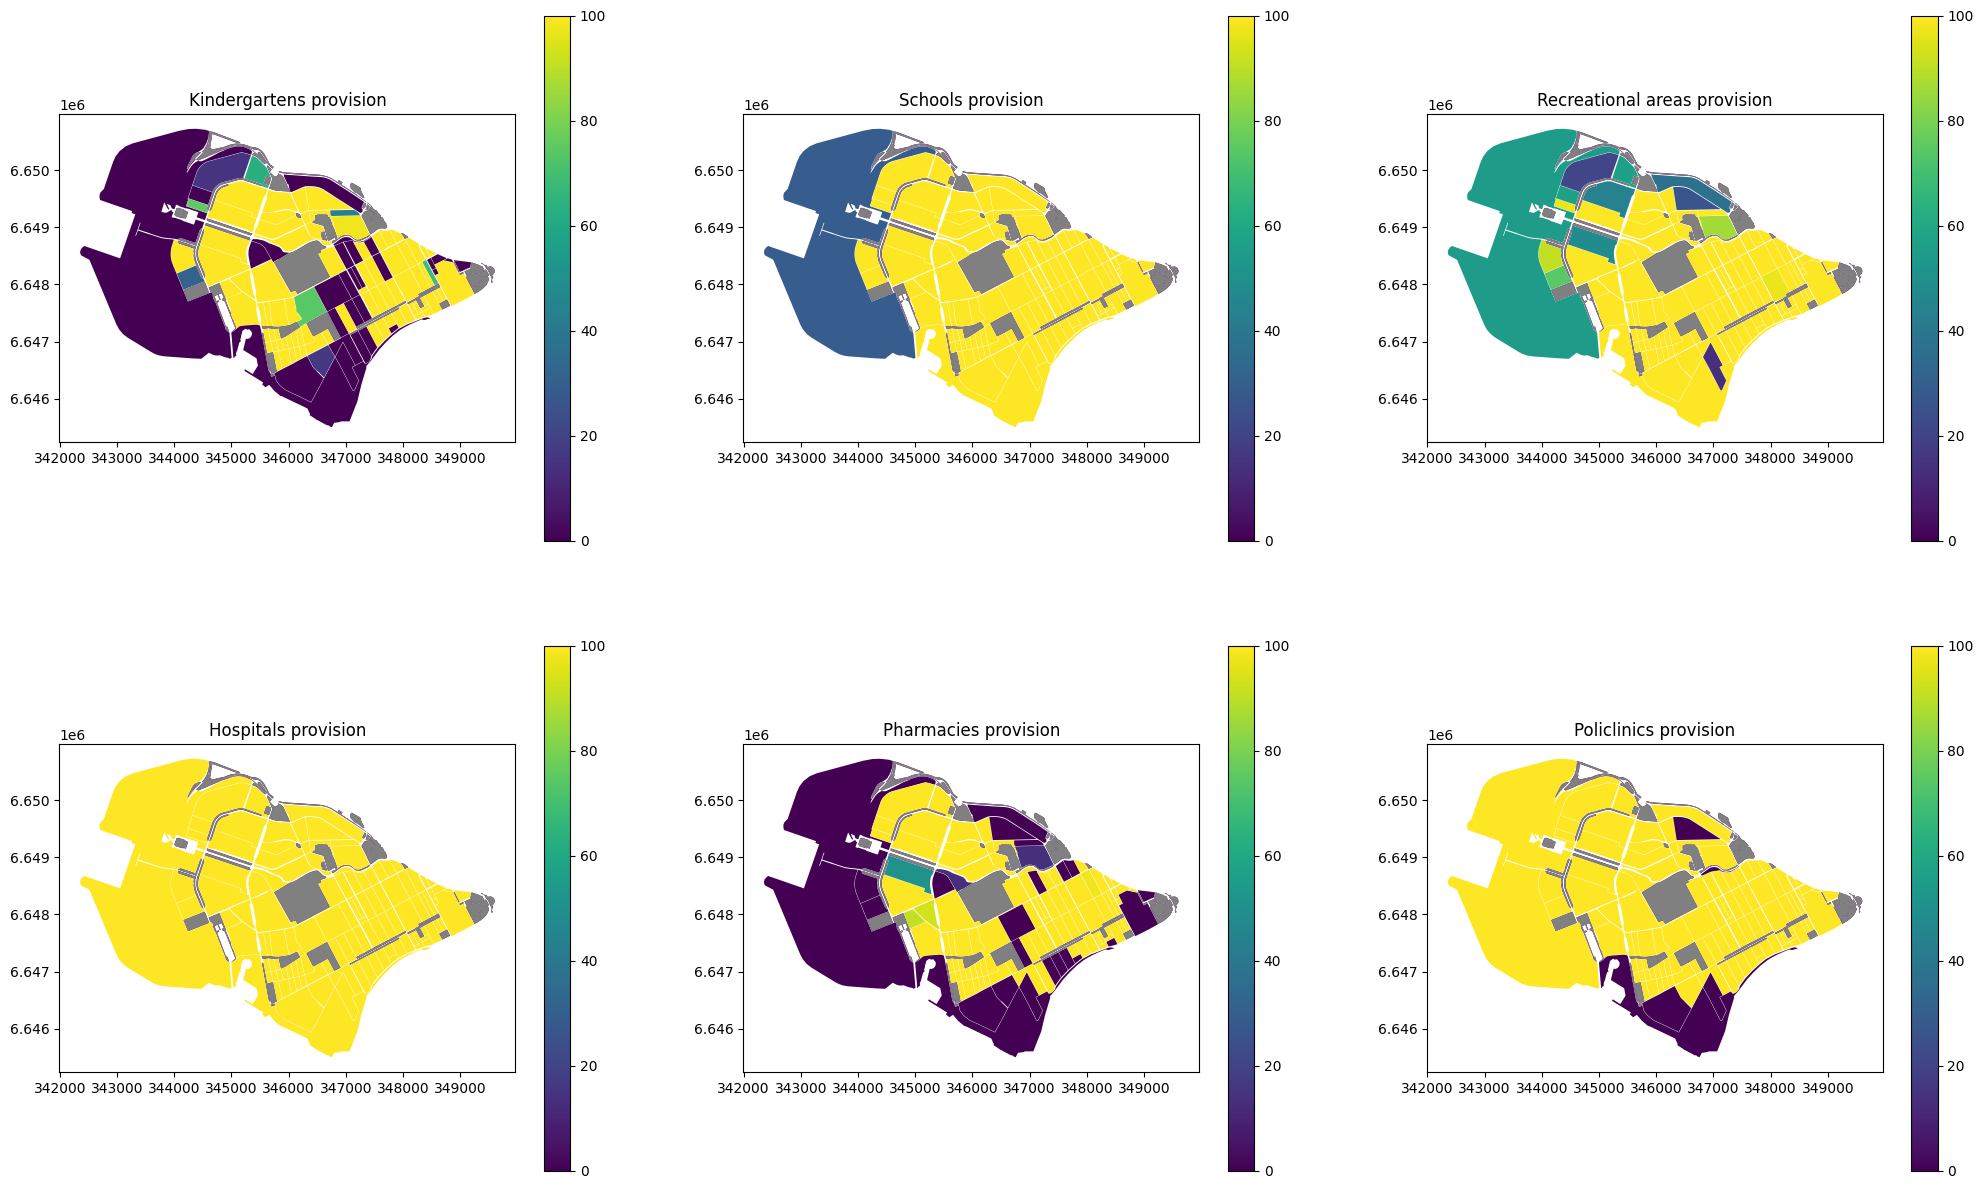

In [ ]:
from matplotlib.gridspec import GridSpec

kindergartens_prov = services_prov["kindergartens"]
schools_prov = services_prov["schools"]
recreational_areas_prov = services_prov["recreational_areas"]
hospitals_prov = services_prov["hospitals"]
pharmacies_prov = services_prov["pharmacies"]
policlinics_prov = services_prov["policlinics"]

fig = plt.figure(figsize=(25, 15))
gs = GridSpec(2, 3, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
kindergartens_prov.plot(column="provision_kindergartens", legend=True, ax=ax1)
ax1.set_title("Kindergartens provision")
kindergartens_prov[kindergartens_prov["population"] == 0].plot(ax=ax1, color="grey", alpha=1)

ax2 = fig.add_subplot(gs[0, 1])
schools_prov.plot(column="provision_schools", legend=True, ax=ax2)
ax2.set_title("Schools provision")
schools_prov[schools_prov["population"] == 0].plot(ax=ax2, color="grey", alpha=1)

ax3 = fig.add_subplot(gs[0, 2])
recreational_areas_prov.plot(column="provision_recreational_areas", legend=True, ax=ax3)
ax3.set_title("Recreational areas provision")
recreational_areas_prov[recreational_areas_prov["population"] == 0].plot(ax=ax3, color="grey", alpha=1)

ax4 = fig.add_subplot(gs[1, 0])
hospitals_prov.plot(column="provision_hospitals", legend=True, ax=ax4)
ax4.set_title("Hospitals provision")
hospitals_prov[hospitals_prov["population"] == 0].plot(ax=ax4, color="grey", alpha=1)

ax5 = fig.add_subplot(gs[1, 1])
pharmacies_prov.plot(column="provision_pharmacies", legend=True, ax=ax5)
ax5.set_title("Pharmacies provision")
pharmacies_prov[pharmacies_prov["population"] == 0].plot(ax=ax5, color="grey", alpha=1)

ax6 = fig.add_subplot(gs[1, 2])
policlinics_prov.plot(column="provision_policlinics", legend=True, ax=ax6)
ax6.set_title("Policlinics provision")
policlinics_prov[policlinics_prov["population"] == 0].plot(ax=ax6, color="grey", alpha=1)

plt.show()


#### Selected area of the city to which the new parameters will be modelled

In [ ]:
block = balance_data(
    gdf=city_model.blocks_aggregated_info,
    polygon=polygon,
    services_prov=services_prov,
)

/Users/mvin/Desktop/masterplanning/build/__editable__.masterplan_tools-0.0.1-py3-none-any/masterplan_tools/method/balancing/balancer.py:140: FutureWarning: Passing 'suffixes' which cause duplicate columns {'id_x'} in the result is deprecated and will raise a MergeError in a future version.
  gdf_ = (gdf_.merge(services_prov[service_type][["id", f"population_unprov_{service_type}"]], left_on="block_id", right_on="id"))
/Users/mvin/Desktop/masterplanning/build/__editable__.masterplan_tools-0.0.1-py3-none-any/masterplan_tools/method/balancing/balancer.py:140: FutureWarning: Passing 'suffixes' which cause duplicate columns {'id_x'} in the result is deprecated and will raise a MergeError in a future version.
  gdf_ = (gdf_.merge(services_prov[service_type][["id", f"population_unprov_{service_type}"]], left_on="block_id", right_on="id"))


In [ ]:
markdown_table = "\n".join(
    (
        "| Option | Techno-economic indicator |",
        "| --- | --- |",
        "\n".join(f"| {key} | {round(value)} |" for key, value in block.items()),
    )
)

pandas_to_markdown(pd.Series(block, name="Option"), "Teckno-economic indicator")

| Option | Teckno-economic indicator |
| --- | --- |
| block_id | 24 |
| area | 40 |
| current_living_area | 5 |
| current_industrial_area | 1 |
| current_population | 14424 |
| current_green_area | 1 |
| floors | 4 |
| population_unprov_schools | 0 |
| population_unprov_kindergartens | 743 |
| population_unprov_recreational_areas | 11305 |
| population_unprov_hospitals | 0 |
| population_unprov_pharmacies | 0 |
| population_unprov_policlinics | 0 |

#### Modelling of new parameters for the selected area with maximisation of the number of inhabitants

In [ ]:
mp = MasterPlan(
    area=block["area"],
    current_living_area=block["current_living_area"],
    current_industrial_area=block["current_industrial_area"],
    current_population=block["current_population"],
    current_green_area=block["current_green_area"],
    current_unprov_schoolkids=block["population_unprov_schools"],
    current_unprov_kids=block["population_unprov_kindergartens"],
    current_unprov_green_population=block["population_unprov_recreational_areas"],
)

updated_block = mp.optimal_solution_indicators()
updated_block["block_id"] = 24

#### Modelled block transformation requirements

In [ ]:
markdown_table = "\n".join(
    (
        "| Option | Techno-economic indicator |\n| --- | --- |",
        "\n".join(f"| {key} | {round(value)} |" for key, value in updated_block.items()),
    )
)

# Markdown(markdown_table)
pandas_to_markdown(pd.Series(updated_block, name="Option"))

| Option | value |
| --- | --- |
| area | 40 |
| population | 14645 |
| b | 30 |
| green_coef_G | 6 |
| living_area | 20 |
| schools_area | 2 |
| schools_capacity | 800 |
| kindergartens_area | 0 |
| kindergartens_capacity | 0 |
| green_area | 4 |
| G_min_capacity | 7092 |
| G_max_capacity | 3546 |
| green_coef_G_capacity | 7092 |
| op_area | 0 |
| parking1_area | 4 |
| parking2_area | 4 |
| block_id | 24 |

In [ ]:
# updated_block_2 = {'area': 39.81881724414382,
#  'population': 30000.0,
#  'b': 29.694473966641496,
#  'green_coef_G': 6.000675103622856,
#  'living_area': 16.759779143393366,
#  'schools_area': 1.3,
#  'schools_capacity': 400.0,
#  'kindergartens_area': 0,
#  'kindergartens_capacity': 300,
#  'green_area': 3.423267273524289,
#  'G_min_capacity': 5705.445455873815,
#  'G_max_capacity': 2852.7227279369076,
#  'green_coef_G_capacity': 5704.8035669478595,
#  'op_area': 0.011877,
#  'parking1_area': 2.993004,
#  'parking2_area': 2.909865,
#  'block_id': 197}

In [ ]:
# Example of changing several quarters
updated_block_dict = {}
updated_block_dict[1] = updated_block
# updated_block_dict[2] = updated_block_2



#### Making changes based on requirements in the data model

In [ ]:
services_graph = nx.Graph()
for service_type in services.keys():
    service_graph = DataGetter().prepare_graph(
        blocks=city_model.city_blocks,
        service_type=service_type,
        buildings=city_model.buildings,
        service_gdf=city_model.services_gdfs[service_type],
        updated_block_info=updated_block_dict,
        accessibility_matrix=city_model.accessibility_matrix,
        services_graph=services_graph,
    )

city_model.services_graph = services_graph

Iterating blocks to prepare graph:   0%|          | 0/28 [00:00<?, ?it/s]

Iterating blocks to prepare graph:   0%|          | 0/32 [00:00<?, ?it/s]

Iterating blocks to prepare graph:   0%|          | 0/151 [00:00<?, ?it/s]

Iterating blocks to prepare graph:   0%|          | 0/7 [00:00<?, ?it/s]

Iterating blocks to prepare graph:   0%|          | 0/29 [00:00<?, ?it/s]

Iterating blocks to prepare graph:   0%|          | 0/9 [00:00<?, ?it/s]

#### Recalculating the provision of services to blocks

In [ ]:
services_prov_nev = {}

for service_type in services.keys():
    provision = ProvisionModel(city_model=city_model, service_name=service_type)
    services_prov_nev[service_type] = provision.run()

Number of blocks with service: schools: 28
Number of residential blocks: 114
Number of blocks total: 199
Number of blocks with an error: 0

Number of blocks with service: kindergartens: 32
Number of residential blocks: 114
Number of blocks total: 199
Number of blocks with an error: 0

Number of blocks with service: recreational_areas: 151
Number of residential blocks: 114
Number of blocks total: 199
Number of blocks with an error: 0

Number of blocks with service: hospitals: 7
Number of residential blocks: 114
Number of blocks total: 199
Number of blocks with an error: 0

Number of blocks with service: pharmacies: 29
Number of residential blocks: 114
Number of blocks total: 199
Number of blocks with an error: 0

Number of blocks with service: policlinics: 9
Number of residential blocks: 114
Number of blocks total: 199
Number of blocks with an error: 0



#### New service provision visualization

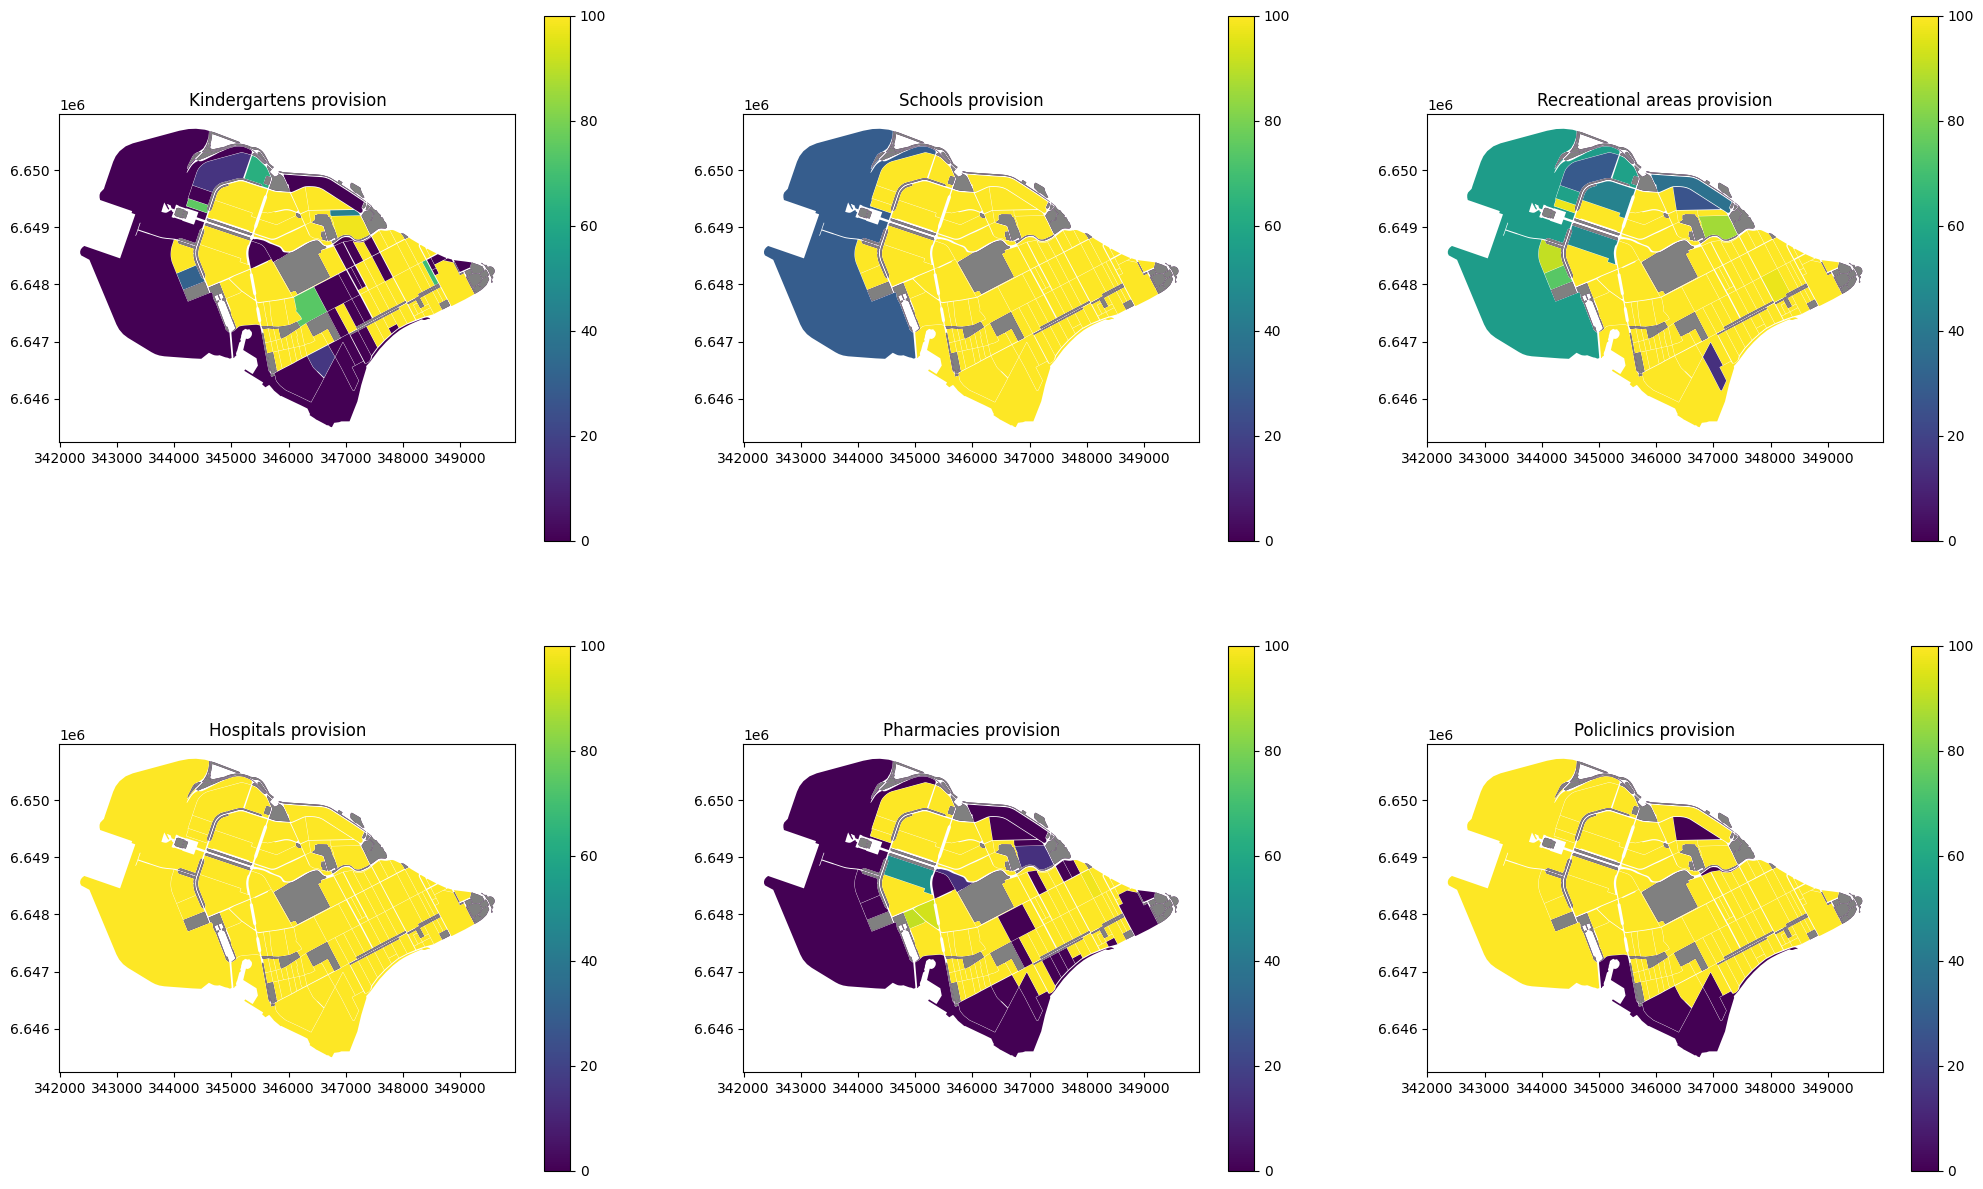

In [ ]:
from matplotlib.gridspec import GridSpec

kindergartens_prov_nev = services_prov_nev["kindergartens"]
schools_prov_nev = services_prov["schools"]
recreational_areas_prov_nev = services_prov_nev["recreational_areas"]
hospitals_prov_nev = services_prov_nev["hospitals"]
pharmacies_prov_nev = services_prov_nev["pharmacies"]
policlinics_prov_nev = services_prov_nev["policlinics"]

fig = plt.figure(figsize=(25, 15))
gs = GridSpec(2, 3, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
kindergartens_prov_nev.plot(column="provision_kindergartens", legend=True, ax=ax1)
ax1.set_title("Kindergartens provision")
kindergartens_prov_nev[kindergartens_prov_nev["population"] == 0].plot(ax=ax1, color="grey", alpha=1)

ax2 = fig.add_subplot(gs[0, 1])
schools_prov_nev.plot(column="provision_schools", legend=True, ax=ax2)
ax2.set_title("Schools provision")
schools_prov_nev[schools_prov_nev["population"] == 0].plot(ax=ax2, color="grey", alpha=1)

ax3 = fig.add_subplot(gs[0, 2])
recreational_areas_prov_nev.plot(column="provision_recreational_areas", legend=True, ax=ax3)
ax3.set_title("Recreational areas provision")
recreational_areas_prov_nev[recreational_areas_prov_nev["population"] == 0].plot(ax=ax3, color="grey", alpha=1)

ax4 = fig.add_subplot(gs[1, 0])
hospitals_prov_nev.plot(column="provision_hospitals", legend=True, ax=ax4)
ax4.set_title("Hospitals provision")
hospitals_prov_nev[hospitals_prov_nev["population"] == 0].plot(ax=ax4, color="grey", alpha=1)

ax5 = fig.add_subplot(gs[1, 1])
pharmacies_prov_nev.plot(column="provision_pharmacies", legend=True, ax=ax5)
ax5.set_title("Pharmacies provision")
pharmacies_prov_nev[pharmacies_prov_nev["population"] == 0].plot(ax=ax5, color="grey", alpha=1)

ax6 = fig.add_subplot(gs[1, 2])
policlinics_prov_nev.plot(column="provision_policlinics", legend=True, ax=ax6)
ax6.set_title("Policlinics provision")
policlinics_prov_nev[policlinics_prov_nev["population"] == 0].plot(ax=ax6, color="grey", alpha=1)

plt.show()

#### Comparison of service provision before and after the territory change

In [ ]:
data = []
before = services_prov["kindergartens"].iloc[24]
after = services_prov_nev["kindergartens"].iloc[24]
for attr in before.index:
    if attr not in ["id", "geometry"]:
        data.append([attr, before[attr], after[attr]])
before = services_prov["schools"].iloc[24]
after = services_prov_nev["schools"].iloc[24]
for attr in before.index:
    if attr not in ["id", "geometry", "population"]:
        data.append([attr, before[attr], after[attr]])
before = services_prov["recreational_areas"].iloc[24]
after = services_prov_nev["recreational_areas"].iloc[24]
for attr in before.index:
    if attr not in ["id", "geometry", "population"]:
        data.append([attr, before[attr], after[attr]])
before = services_prov["hospitals"].iloc[24]
after = services_prov_nev["hospitals"].iloc[24]
for attr in before.index:
    if attr not in ["id", "geometry", "population"]:
        data.append([attr, before[attr], after[attr]])
before = services_prov["policlinics"].iloc[24]
after = services_prov_nev["policlinics"].iloc[24]
for attr in before.index:
    if attr not in ["id", "geometry", "population"]:
        data.append([attr, before[attr], after[attr]])
before = services_prov["pharmacies"].iloc[24]
after = services_prov_nev["pharmacies"].iloc[24]
for attr in before.index:
    if attr not in ["id", "geometry", "population"]:
        data.append([attr, before[attr], after[attr]])        
result = pd.DataFrame(data, columns=["Attribute", "Before", "After"])


pandas_to_markdown(result)

| Attribute | Before | After |
| --- | --- | --- |
| provision_kindergartens | 15 | 15 |
| population_prov_kindergartens | 136 | 136 |
| population_unprov_kindergartens | 743 | 757 |
| population | 14424 | 14645 |
| provision_schools | 100 | 100 |
| population_prov_schools | 1730 | 1757 |
| population_unprov_schools | 0 | 0 |
| provision_recreational_areas | 21 | 28 |
| population_prov_recreational_areas | 3118 | 4224 |
| population_unprov_recreational_areas | 11305 | 10420 |
| provision_hospitals | 100 | 100 |
| population_prov_hospitals | 129 | 131 |
| population_unprov_hospitals | 0 | 0 |
| provision_policlinics | 100 | 100 |
| population_prov_policlinics | 389 | 395 |
| population_unprov_policlinics | 0 | 0 |
| provision_pharmacies | 100 | 100 |
| population_prov_pharmacies | 721 | 732 |
| population_unprov_pharmacies | 0 | 0 |

In [ ]:
df_filtered_1 = services_prov["hospitals"][services_prov["hospitals"]['population'] > 0]
hospitals_all = df_filtered_1['provision_hospitals'].sum(numeric_only=True) / len(df_filtered_1)

df_filtered_2 = services_prov["policlinics"][services_prov["policlinics"]['population'] > 0]
policlinics_all = df_filtered_2['provision_policlinics'].sum(numeric_only=True) / len(df_filtered_2)

df_filtered_3 = services_prov["recreational_areas"][services_prov["recreational_areas"]['population'] > 0]
recreational_areas_all = df_filtered_3['provision_recreational_areas'].sum(numeric_only=True) / len(df_filtered_3)

df_filtered_4 = services_prov["pharmacies"][services_prov["pharmacies"]['population'] > 0]
pharmacies_all = df_filtered_4['provision_pharmacies'].sum(numeric_only=True) / len(df_filtered_4)

total_prov = (hospitals_all + policlinics_all + recreational_areas_all + pharmacies_all)/4


df_filtered_5 = services_prov_nev["hospitals"][services_prov["hospitals"]['population'] > 0]
hospitals_all_new = df_filtered_5['provision_hospitals'].sum(numeric_only=True) / len(df_filtered_5)

df_filtered_6 = services_prov_nev["policlinics"][services_prov["policlinics"]['population'] > 0]
policlinics_all_new  = df_filtered_6['provision_policlinics'].sum(numeric_only=True) / len(df_filtered_6)

df_filtered_7 = services_prov_nev["recreational_areas"][services_prov_nev["recreational_areas"]['population'] > 0]
recreational_areas_all_new  = df_filtered_7['provision_recreational_areas'].sum(numeric_only=True) / len(df_filtered_7)

df_filtered_8 = services_prov["pharmacies"][services_prov["pharmacies"]['population'] > 0]
pharmacies_all_new = df_filtered_8['provision_pharmacies'].sum(numeric_only=True) / len(df_filtered_8)

total_prov_new  = (hospitals_all_new  + policlinics_all_new  + recreational_areas_all_new + pharmacies_all_new )/4

print(f"Total provision before {total_prov}")
print(f"Total provision after {total_prov_new}")

Total provision before 92.02631578947367
Total provision after 92.04166666666666
